In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import os
import shutil
from pathlib import Path
import pickle
from typing import Optional
import subprocess

import torch

from rich import print
from rich.pretty import pprint as pp

In [2]:
from src.code_gen import code_gen_v2
from src.plotting import plot_graph, plot_grad_graph
from src.profiling import profileit
from src.inr_dsp import Project, FPX

## Load Data

In [3]:
model_fp = Path("./src/test_files_64/new_grad_lastdim_small.pkl")
# model_fp = Path("./src/test_files_64/new_grad_lastdim_all.pkl")

with open(model_fp, "rb") as f:
    G_data = pickle.load(f)

print(G_data)

DiGraph with 108 nodes and 131 edges

## Plot Computation Graph

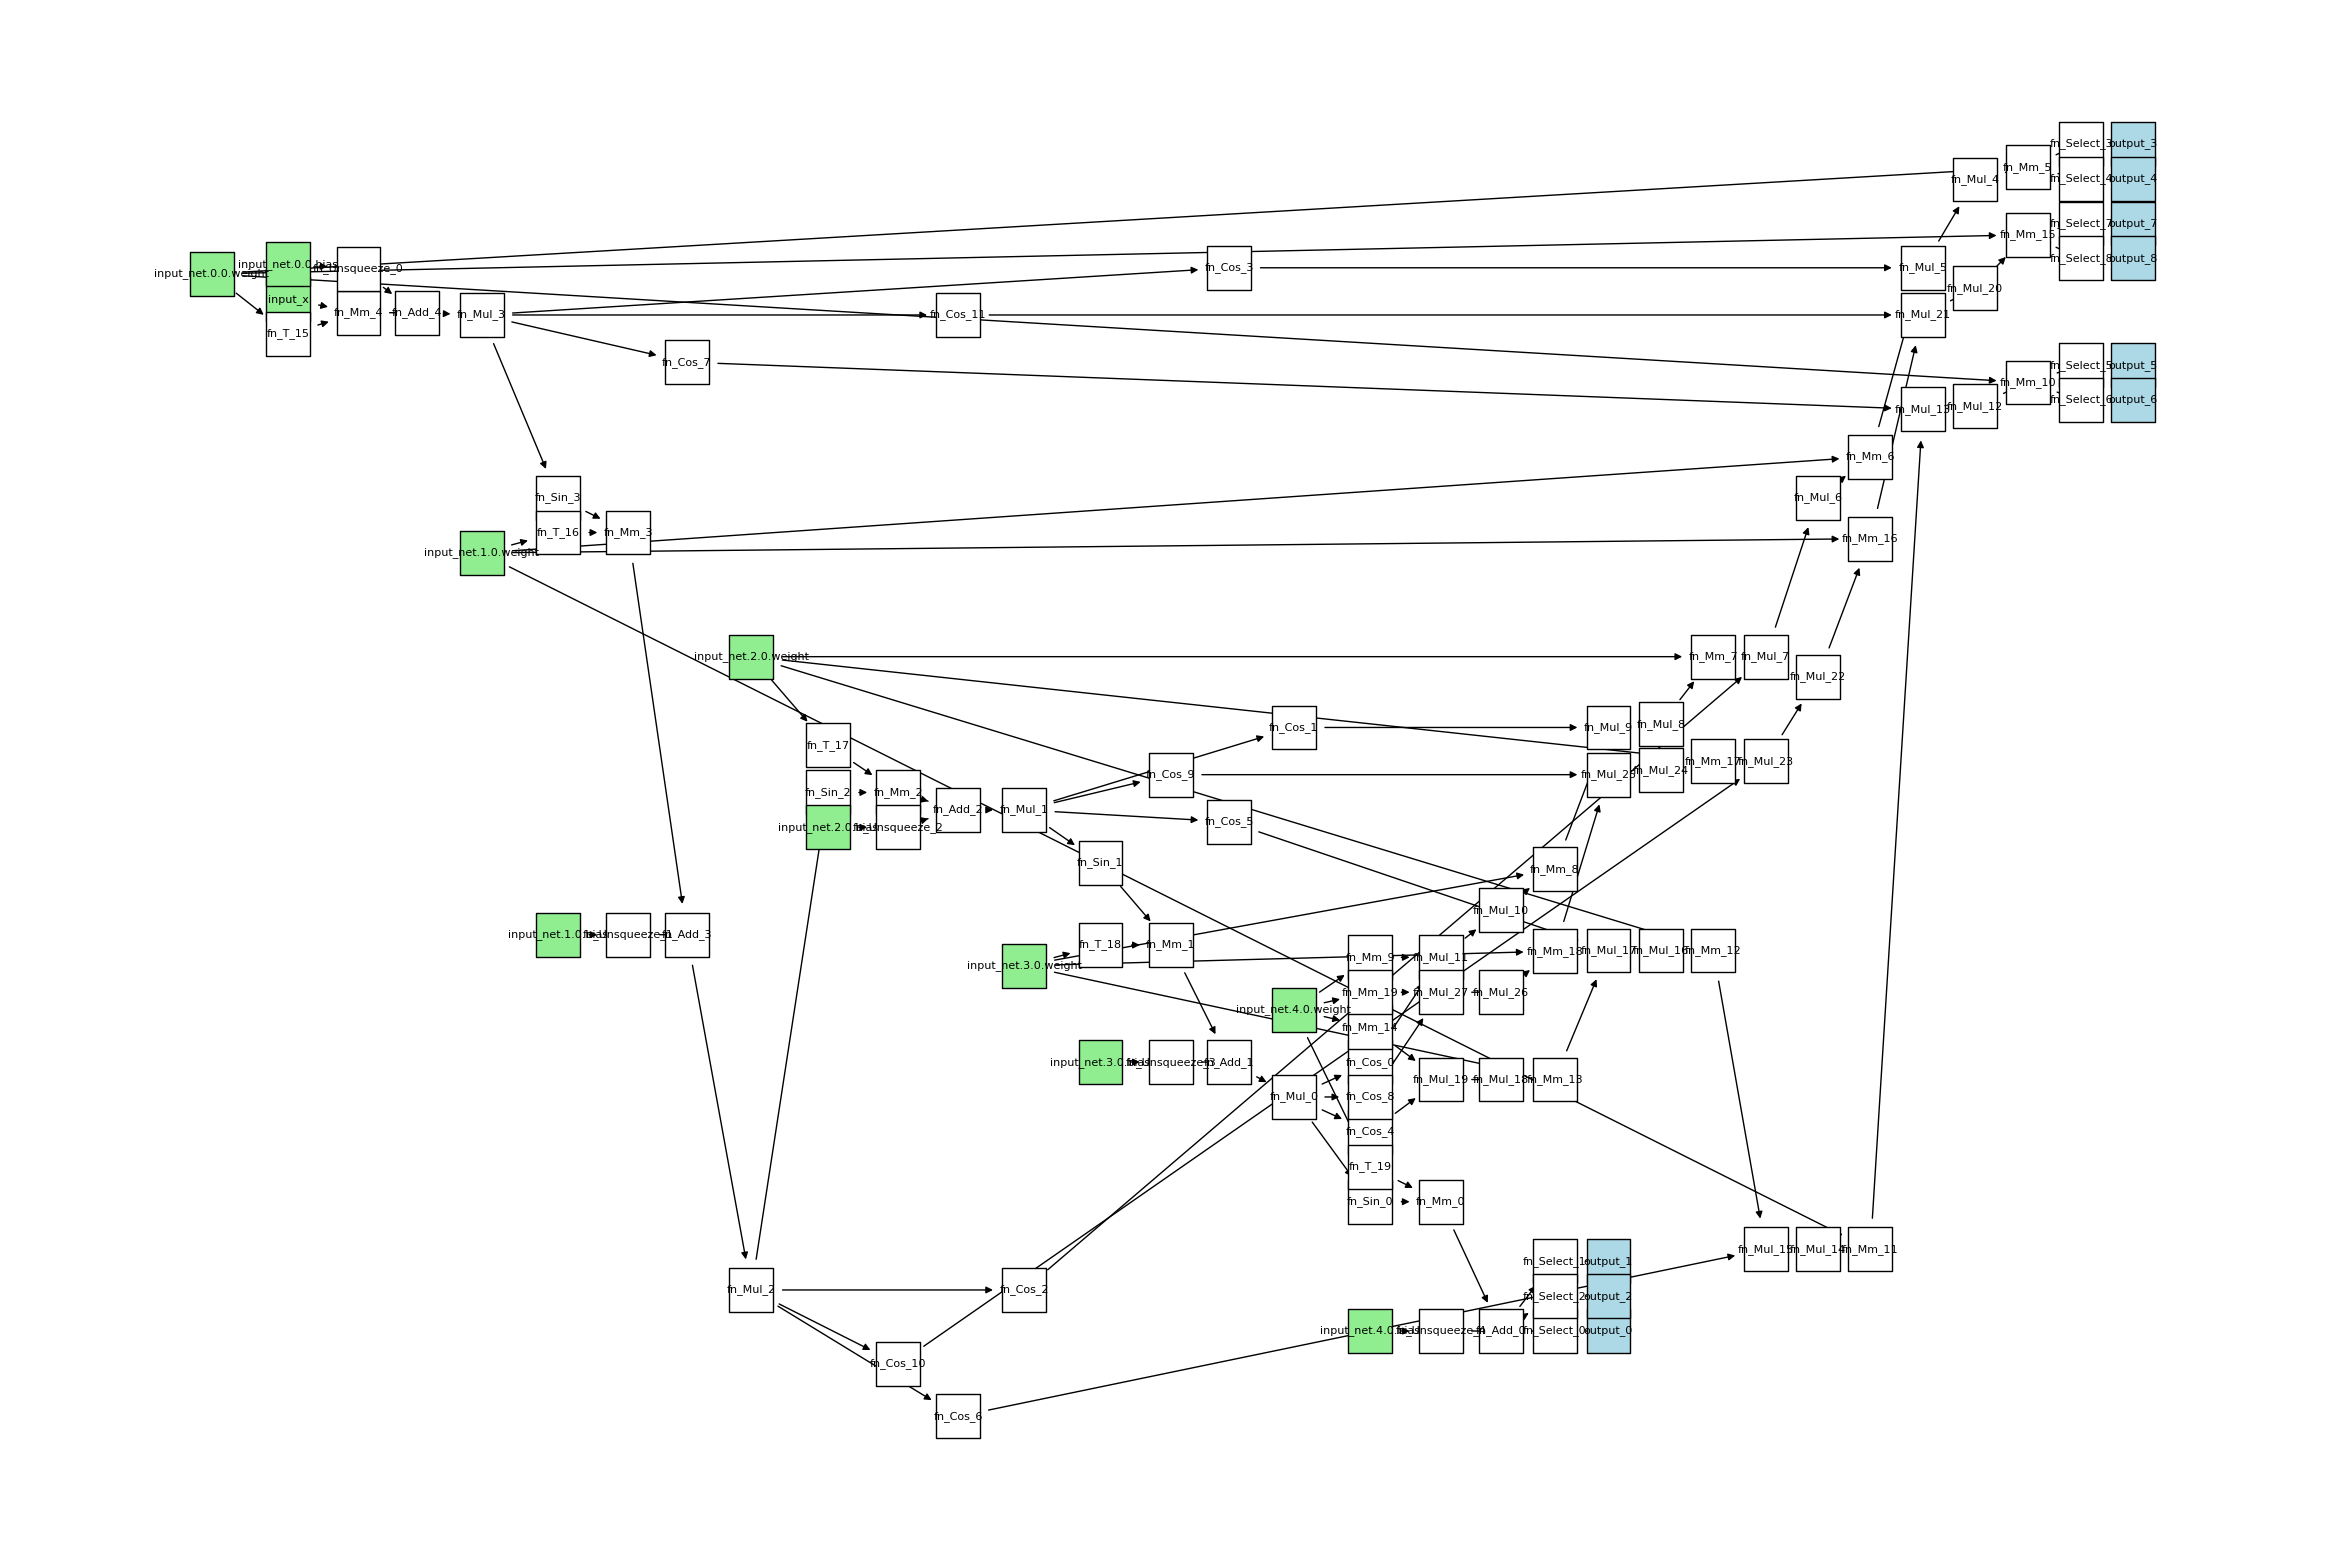

In [10]:
color_map = {
    "input": "lightgreen",
    "output": "lightblue",
    "fn": "white",
}

def plot_graph(G: nx.DiGraph, figure_fp: Optional[Path] = None):
    G = G.copy()
    for node in G.nodes:
        for key in ["shape"]:
            if key in G.nodes[node]:
                del G.nodes[node][key]

    fig, ax = plt.subplots(1,1, figsize=(30, 20))
    pos = nx.nx_agraph.graphviz_layout(G, prog="dot", args="-Grankdir=LR -Goverlap=false -Gnodesep=1.0 -Granksep=1.0")
    colors = [color_map[G.nodes[node]["type"]] for node in G.nodes]
    nx.draw(G, pos, with_labels=True, node_shape="s", font_size=8, ax=ax, node_color=colors, edgecolors="black", node_size=1000)
    if figure_fp:
        os.makedirs(figure_fp.parent, exist_ok=True)
        plt.savefig(figure_fp, dpi=300)
    else:
        plt.show()


def write_to_dot(G: nx.DiGraph, fp: Path):
    os.makedirs(fp.parent, exist_ok=True)
    nx.nx_agraph.write_dot(G, fp)

plot_graph(G_data)
# write_to_dot(G_data, Path('./test_output/graph_debug.dot'))
# print(G_data.nodes(data=True))


## Code Generation

In [5]:
vitis_hls_bin = "/tools/software/xilinx/Vitis_HLS/2021.1/bin/vitis_hls"

proj = Project(
    "my_model_64_p64",
    G_data,
    Path("/usr/scratch/skaram7/inr_dsp_builds/"),
    float_or_fixed="fixed",
    fpx=FPX(32, 10),
    # float_or_fixed="float",
    dataflow=True,
    clock_speed=3.33,
    fpga_part="xcu50-fsvh2104-2-e",
    n_jobs=4,
    vitis_hls_bin=vitis_hls_bin,
    mm_p=64,
    mm_version="v2"
)

In [7]:
GOOD_FIFO_DEPTHS_64 = {
    # "fn_Mul_9__in_1_stream": 16384,
    # "fn_Mul_7__in_1_stream": 16384,
    # "fn_Mul_5__in_1_stream": 16384,
    # "fn_Mul_17__in_1_stream": 16384,
    # "fn_Mul_15__in_1_stream": 16384,
    # "fn_Mul_13__in_1_stream": 16384,
    # "fn_Mul_25__in_1_stream": 16384,
    # "fn_Mul_23__in_1_stream": 16384,
    # "fn_Mul_21__in_1_stream": 16384
}

In [11]:
proj.gen_hw_model(fifo_depths=GOOD_FIFO_DEPTHS_64)
print(proj.model_dir)

/usr/scratch/skaram7/inr_dsp_builds/my_model_64_p64

## C Simulation

In [12]:
proj.gen_testbench()
proj.gen_testbench_data()
proj.gen_makefile()
proj.build_and_run_testbench()

/tools/software/xilinx/Vitis_HLS/2021.1/lnx64/tools/clang-3.9/bin/clang++ ./*.cpp -o result -L"/tools/software/xilinx/Vitis_HLS/2021.1/lnx64/lib/csim" -lhlsmc++-CLANG39 -Wl,-rpath,"/tools/software/xilinx/Vitis_HLS/2021.1/lnx64/lib/csim" -Wl,-rpath,"/tools/software/xilinx/Vitis_HLS/2021.1/lnx64/tools/fpo_v7_0" -Wl,--sysroot=/ -fPIC -O3 -g -lm -std=c++14 -I "." -I "/tools/software/xilinx/Vitis_HLS/2021.1/include" -I "/tools/software/xilinx/Vitis_HLS/2021.1/include/etc" -I "/tools/software/xilinx/Vitis_HLS/2021.1/include/utils" -I "/tools/software/xilinx/Vitis_HLS/2021.1/lnx64/tools/fpo_v7_0" -I "/tools/software/xilinx/Vitis_HLS/2021.1/lnx64/tools/fft_v9_1" -I "/tools/software/xilinx/Vitis_HLS/2021.1/lnx64/tools/fir_v7_0" -I "/tools/software/xilinx/Vitis_HLS/2021.1/lnx64/tools/dds_v6_0" -I "/tools/software/xilinx/Vitis_HLS/2021.1/lnx64/lib/csim" -D__SIM_FPO__ -D__SIM_OPENCV__ -D__SIM_FFT__ -D__SIM_FIR__ -D__SIM_DDS__ -D__DSP48E1__

FAIL
output_0_top_out_float = [  000.398601  000.699944  

In [10]:
# proj.gather_testbench_data()
# ignore this for now its not correct

## HLS Synthesis

In [13]:
proj.gen_vitis_hls_tcl_script()
proj.run_vitis_hls_synthesis()

Launching HLS synthesis...


In [14]:
synth_data = proj.gather_synthesis_data()
pp(synth_data)

{
│   'clock_period': 3.33,
│   'worst_case_runtime_cycles': 4952639.0,
│   'worst_case_runtime_ns': 16492287.870000001,
│   'worst_case_runtime': 0.01649228787,
│   'bram': 347,
│   'dsp': 3199,
│   'ff': 387907,
│   'lut': 502224,
│   'uram': 0
}